In [5]:
import ROOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.signal import find_peaks
import os
from scipy.stats import norm, chisquare
from sklearn.mixture import GaussianMixture

# Enable implicit multi-threading (optional)
ROOT.ROOT.EnableImplicitMT()

%matplotlib widget

In [6]:
# GEM layer boundaries in cm
layer1_z = 0.0
layer2_z = -0.2
layer3_z = -0.4
readout_z = -0.6
drift_electrode_z = 0.3

def det_layer(z):
    """
    Determine GEM layer based on electron z-coordinate.

    Parameters:
        z (float): z-position of the electron

    Returns:
        int: layer index (0 to 3)
    """
    if z > layer1_z:
        return 3  # Between 1st GEM and drift electrode
    elif z > layer2_z:
        return 2  # Between 1st and 2nd GEM
    elif z > layer3_z:
        return 1  # Between 2nd and 3rd GEM
    else:
        return 0  # Between 3rd GEM and readout


In [7]:
def spread_gausses(x2, y2, z2, g, bin_width, minx):

    x_bin_centers = np.arange(-20, 20, bin_width)
    x_bin_vals = np.zeros(len(x_bin_centers))
    y_bin_centers = np.arange(-20, 20, bin_width)
    y_bin_vals = np.zeros(len(y_bin_centers))

    layer_spreads = [0.001, 0.12 ,np.sqrt(2)*0.12, np.sqrt(3)*0.12]

    for x, y, z, g in zip(x2, y2, z2, g):

        if x < minx: continue
        # Find the bin index for x and y
        x_idx = np.searchsorted(x_bin_centers, x) - 1
        y_idx = np.searchsorted(y_bin_centers, y) - 1

        # Determine which layer this electron is in
        layer = det_layer(z)
        spread = layer_spreads[layer]

        # Smear a Gaussian over nearby bins for x
        for dx in range(-2,3):
            idx = x_idx + dx
            if 0 <= idx < len(x_bin_centers):
                p = norm.cdf(x_bin_centers[idx] + bin_width/2, loc=x, scale=spread) - norm.cdf(x_bin_centers[idx]-bin_width/2, loc=x, scale=spread)
                weight = g * p
                x_bin_vals[idx] += weight
                # print(f'smeared, {p}, {g}, at x={x_bin_centers[idx]} from {x}, idx {idx} dx {dx}')

        # Smear a Gaussian over nearby bins for y
        for dy in range(-2, 3):
            idy = y_idx + dy
            if 0 <= idy < len(y_bin_centers):
                p = norm.cdf(y_bin_centers[idy]+bin_width/2, loc=y, scale=spread) - norm.cdf(y_bin_centers[idy]-bin_width/2, loc=y, scale=spread)
                weight = g * p
                y_bin_vals[idy] += weight
    
    return x_bin_centers, x_bin_vals, y_bin_centers, y_bin_vals

In [8]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

In [9]:
def gaussian_reconstruction(bin_tick, bin_count):

    # Initial guess: amplitude, mean, std dev
    peak_indx = np.argwhere(bin_count == np.max(bin_count))[0][0]
    p0 = [max(bin_count), bin_tick[peak_indx], 1]
    # p0 = [max(bin_tick), 0, 1]

    # Fit Gaussian
    try:
        popt, _ = curve_fit(gaussian, bin_tick, bin_count, p0=p0)
        return popt # Return the mean (mu)
    except RuntimeError:
        print("Fit failed.")
        return np.nan, np.nan, np.nan

In [10]:
def cutoff_reconstruction(bin_tick, bin_count, p1=10, p2=90):
    pdf = bin_count / np.sum(bin_count)
    cdf = np.cumsum(pdf)
    ps = np.interp([p1/100., p2/100.], cdf, bin_tick)

    return np.nan, ps.mean(), np.nan

In [11]:
def peak_reconstruction(bin_tick, bin_count, prominence=0.2):
    # Find peaks with high prominence
    peaks, properties = find_peaks(bin_count, prominence=prominence * np.max(bin_count))
    if len(peaks) == 0:
        return gaussian_reconstruction(bin_tick, bin_count)
    # Average the coordinates of the peaks
    mean_peak = np.mean(bin_tick[peaks])
    return np.nan, mean_peak, np.nan


In [12]:
def mean_reconstruction(bin_tick, bin_count,):
    return np.nan, np.average(bin_tick, weights=bin_count/bin_count.sum()), np.nan

In [13]:
def no_weight_mean_reconstruction(bin_tick, bin_count):

    above_thresh = bin_count > 800
    if np.any(above_thresh):
        indices = np.where(above_thresh)[0]
        mid_idx = indices[len(indices) // 2]
        mid_val = bin_tick[mid_idx]
    else:
        mid_val = np.nan
    
    return np.nan, mid_val, np.nan

In [14]:
def median_reconstruction(bin_tick, bin_count,):
    return np.nan, np.median(bin_tick), np.nan

# Load ROOT Files

In [15]:
file = ROOT.TFile.Open("./angle_res/30-60deg.root")
if not file or file.IsZombie():
    print("Error opening file.")


# Get the TTree
tree = file.Get("electrons")
if not tree:
    print("Tree not found.")

# Set up the branch name you want to extract
X_branch = "xf"
Y_branch = 'yf'
T_branch = 'tf'

# Use RDataFrame for convenience
df = ROOT.RDataFrame(tree)

# Convert the branch to a NumPy array
x_arrays = np.array(df.AsNumpy([X_branch])[X_branch]) * 10 # Convert to mm
y_arrays = np.array(df.AsNumpy([Y_branch])[Y_branch]) * 10 # Convert to mm
t_arrays = np.array(df.AsNumpy([T_branch])[T_branch]) # in ns


# Get the angle for this event
tree = file.Get("events")
if not tree:
    print("Tree not found.")
df = ROOT.RDataFrame(tree)
thetas = np.array(df.AsNumpy(['theta'])['theta'])
thetas = np.radians(thetas)  # Convert to radians
x0s = np.array(df.AsNumpy(['start_x'])['start_x']) * 10
y0s = np.array(df.AsNumpy(['start_y'])['start_y'])* 10

xts = np.array(df.AsNumpy(['true_x'])['true_x']) * 10
yts = np.array(df.AsNumpy(['true_y'])['true_y']) * 10

layer_1xs = x0s+3 * np.tan(thetas)
layer_2xs = x0s+5 * np.tan(thetas)
layer_3xs = x0s+7 * np.tan(thetas)


In [16]:
tree = file.Get("sec_electrons")
if not tree:
    print("Tree not found.")
    exit()

df = ROOT.RDataFrame(tree)

X_branch = "x"
Y_branch = 'y'
Z_branch = 'z'
G_branch = 'gain'

# Convert the branch to a NumPy array
x2_arrays = np.array(df.AsNumpy([X_branch])[X_branch]) * 10 # Convert to mm
y2_arrays = np.array(df.AsNumpy([Y_branch])[Y_branch]) * 10 # Convert to mm
z2_arrays = np.array(df.AsNumpy([Z_branch])[Z_branch]) * 10 # Convert to mm
g_arrays = np.array(df.AsNumpy([G_branch])[G_branch]) 

In [17]:
print(np.argwhere(np.degrees(thetas)>50))

[]


/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_13035/4214720934.py:21: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


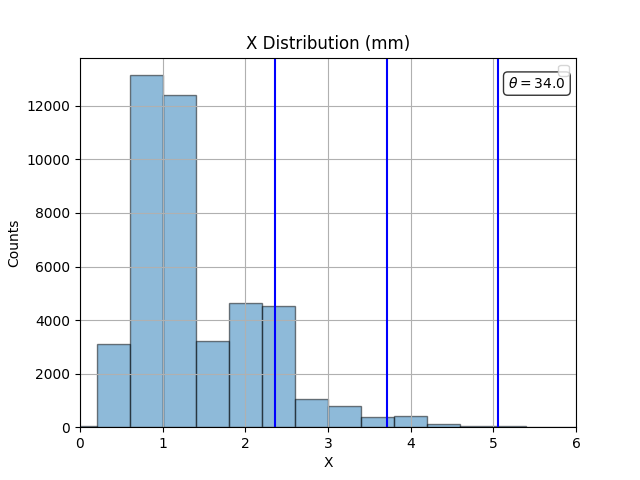

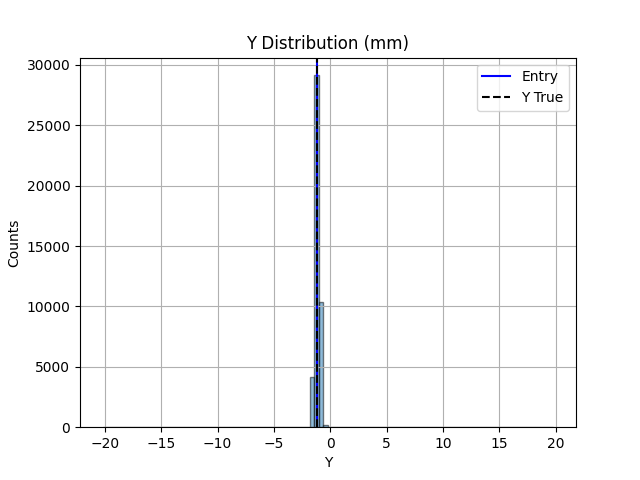

In [ ]:
bin_width = 0.4
i=5

x_bin_centers, x_bin_vals, y_bin_centers, y_bin_vals = spread_gausses(
    x2_arrays[i], y2_arrays[i], z2_arrays[i], g_arrays[i], bin_width, x0s[i]
)

plt.figure()
plt.grid(True)
plt.bar(x_bin_centers, x_bin_vals, width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.axvline(layer_1xs[i], color='b', )
plt.axvline(layer_2xs[i], color='b',)
plt.axvline(layer_3xs[i], color='b',)
# plt.axvline(x0s[i], color='b', label='Entry')
# plt.axvline(xts[i], color='0', label='X True', linestyle='--')
plt.text(0.98, 0.95, f'$\\theta = {np.degrees(thetas[i]):.1f}$ ', transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
plt.xlabel('X')
plt.ylabel('Counts')
plt.title('X Distribution (mm)')
plt.legend()

plt.xlim(0,6)
plt.show()

plt.figure()
plt.grid(True)
plt.bar(y_bin_centers, y_bin_vals, width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.axvline(y0s[i], color='b', label='Entry')
plt.axvline(yts[i], color='0', label='Y True', linestyle='--')
plt.xlabel('Y')
plt.ylabel('Counts')
plt.title('Y Distribution (mm)')
# plt.legend()
plt.show()

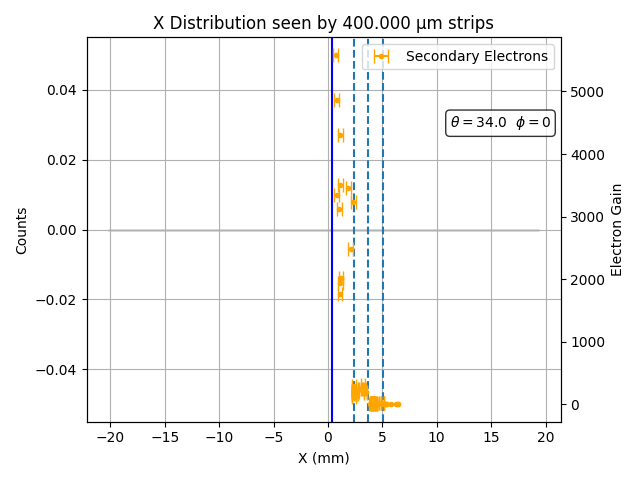

In [18]:
fig, ax1 = plt.subplots()

xerr = []
for x in x2_arrays[i]:
    if x < layer_1xs[i]:
        xerr.append(np.sqrt(3) * 0.12)
    elif x < layer_2xs[i]:
        xerr.append(np.sqrt(2) * 0.12)
    elif x < layer_3xs[i]:
        xerr.append(0.12)
    else:
        xerr.append(np.nan)

bins = x_bin_centers - bin_width / 2
# Histogram on left y-axis
counts, bin_edges, patches = ax1.hist(x_arrays[i], bins=bins, edgecolor='black', alpha=0.75)
ax1.set_xlabel('X (mm)')
ax1.set_ylabel('Counts')
ax1.tick_params(axis='y')

ax1.text(0.98, 0.8, f'$\\theta = {np.degrees(thetas[i]):.1f}$  $\\phi = 0$', transform=ax1.transAxes,
         fontsize=10, verticalalignment='top', horizontalalignment='right', bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))


# Add vertical layer lines
for lx in [layer_1xs[i], layer_2xs[i], layer_3xs[i]]:
    ax1.axvline(lx, linestyle='--')

plt.axvline(x0s[i], color='b', label='Layer 3')

# Second y-axis for gain
ax2 = ax1.twinx()
ax2.errorbar(x2_arrays[i], g_arrays[i], xerr=xerr, fmt='o', capsize=5, markersize=3, label='Secondary Electrons', color='orange')
ax2.set_ylabel('Electron Gain',)
ax2.tick_params(axis='y',)


# Title and grid
plt.title(f'X Distribution seen by {bin_width*1000:.3f} µm strips')
plt.legend()
ax1.grid(True)

fig.tight_layout()
plt.show()

# Spread Gaussian For All Data

In [19]:
save_new = True
all_x = np.zeros((len(x2_arrays), len(x_bin_centers)))
all_y = np.zeros((len(y2_arrays), len(y_bin_centers)))
histx_ticks = np.zeros((len(y2_arrays), len(y_bin_centers)))
histy_ticks = np.zeros((len(y2_arrays), len(y_bin_centers)))

for indx, (x, y, z, g, x0) in enumerate(zip(x2_arrays, y2_arrays, z2_arrays, g_arrays, x0s)):
    # if indx == 1: break
    print(indx)
    xbin, a, ybin, b = spread_gausses(x,y,z,g, bin_width, x0)
    all_x[indx] = a
    all_y[indx] = b
    histx_ticks[indx] = xbin
    histy_ticks[indx] = xbin

    # plt.figure()
    # plt.plot(histy_ticks[indx],all_y[indx] )

if save_new:
    np.savez('./angle_res/50-70.npz', angles = thetas, x=all_x, y=all_y, xbin=histx_ticks, ybin=histy_ticks)

# load = np.load('./high_angle_5000Events.npz')
# all_x = load['x']
# all_y = load['y']
# histx_ticks = load['xbin']
# histy_ticks = load['ybin']


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [20]:
all_x[1]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.78353265e-02,
       2.19142302e+02, 1.99967539e+04, 8.98304190e+04, 4.13032309e+04,
       7.31958927e+04, 3.39922044e+04, 5.28686393e+03, 1.84519219e+02,
       6.00734356e+02, 6.33385279e+02, 3.56539245e+02, 6.35000000e+02,
      

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
620.9733310742871
0.0
0.0
0.0
0.0
0.0
0.0
0.

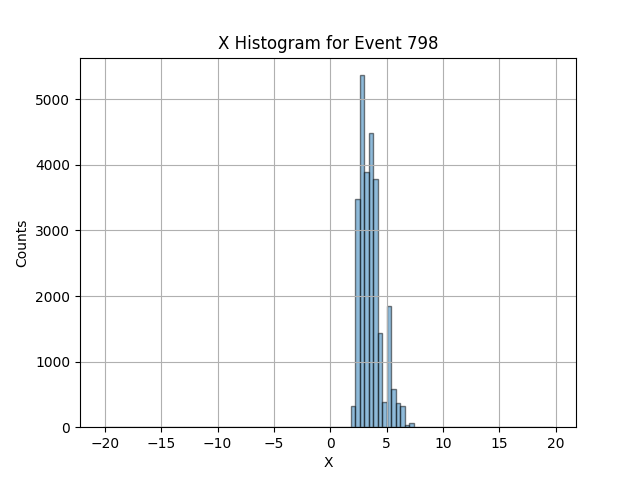

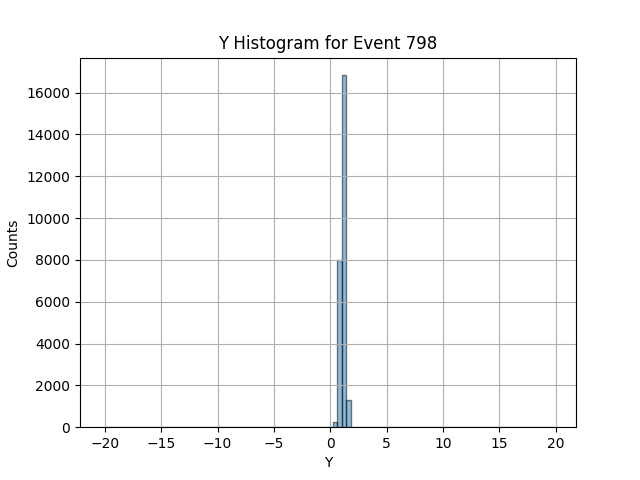

In [21]:
i = 798

plt.figure()
plt.bar(histx_ticks[i], all_x[i], width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.xlabel('X')
plt.ylabel('Counts')
plt.title(f'X Histogram for Event {i}')
plt.grid(True)


plt.figure()
plt.bar(histy_ticks[i], all_y[i], width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.xlabel('Y')
plt.ylabel('Counts')
plt.title(f'Y Histogram for Event {i}')
plt.grid(True)

for xvals, theta in zip(all_x, thetas):
    threshold = 0.2 * np.median(xvals)
    print(threshold)

# Do Reconstruction

In [31]:
recon_x = np.zeros(len(all_x))
recon_y = np.zeros(len(all_y))

recon_x2 = np.zeros(len(all_x))
recon_y2 = np.zeros(len(all_y))

recon_x3 = np.zeros(len(all_x))
recon_y3 = np.zeros(len(all_y))

recon_x4 = np.zeros(len(all_x))
recon_y4 = np.zeros(len(all_y))

fitx_a = np.zeros(len(all_y))
fitx_mu = np.zeros(len(all_y))
fitx_mu2 = np.zeros(len(all_y))
fitx_mu3 = np.zeros(len(all_y))
fitx_sig = np.zeros(len(all_y))

fity_a = np.zeros(len(all_y))
fity_mu = np.zeros(len(all_y))
fity_mu2 = np.zeros(len(all_y))
fity_mu3 = np.zeros(len(all_y))
fity_sig = np.zeros(len(all_y))

for i, (x, y) in enumerate(zip(all_x, all_y)):
    # if i==1: break
    # plt.figure()
    # plt.plot(histy_ticks[0], y)
    print(i)
    fitx_a[i], fitx_mu[i], fitx_sig[i] = gaussian_reconstruction(histx_ticks[0], x) #peak_reconstruction(histx_ticks[0], x, prominence=0.3)
    fitx_a[i], fitx_mu2[i], fitx_sig[i] = mean_reconstruction(histx_ticks[0], x) 
    fitx_a[i], fitx_mu3[i], fitx_sig[i] = cutoff_reconstruction(histx_ticks[0], x) 

    fity_a[i], fity_mu[i], fity_sig[i] = gaussian_reconstruction(histy_ticks[0], y)
    fity_a[i], fity_mu2[i], fity_sig[i] = mean_reconstruction(histy_ticks[0], y)
    fity_a[i], fity_mu3[i], fity_sig[i] = median_reconstruction(histy_ticks[0], y)


    recon_x[i] = fitx_mu[i]
    recon_y[i] = fity_mu[i]

    recon_x2[i] = fitx_mu2[i]
    recon_y2[i] = fity_mu2[i]

    recon_x3[i] = fitx_mu3[i]
    recon_y3[i] = fity_mu3[i]

res_x = recon_x - xts
res_y = recon_y - yts

res_x2 = recon_x2 - xts
res_y2 = recon_y2 - yts

res_x3 = recon_x3 - xts
res_y3 = recon_y3 - yts

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_39268/2410485943.py:10: OptimizeWarning: Covariance of the parameters could not be estimated
  popt, _ = curve_fit(gaussian, bin_tick, bin_count, p0=p0)


357
358
359
360
361
362
363
364
365
366
367
368
369
370
371
372
373
374
375
376
377
378
379
380
381
382
383
384
385
386
387
388
389
390
391
392
393
394
395
396
397
398
399
400
401
402
403
404
405
406
407
408
409
410
411
412
413
414
415
416
417
418
419
420
421
422
423
424
425
426
427
428
429
430
431
432
433
434
435
436
437
438
439
440
441
442
443
444
445
446
447
448
449
450
451
452
453
454
455
456
457
458
459
460
461
462
463
464
465
466
467
468
469
470
471
472
473
474
475
476
477
478
479
480
481
482
483
484
485
486
487
488
489
490
491
492
493
494
495
496
497
498
499
500
501
502
503
504
505
506
507
508
509
510
511
512
513
514
515
516
517
518
519
520
521
522
523
524
525
526
527
528
529
530
531
532
533
534
535
536
537
538
539
540
541
542
543
544
545
546
547
548
549
550
551
552
553
554
555
556
557
558
559
560
561
562
563
564
565
566
567
568
569
570
571
572
573
574
575
576
577
578
579
580
581
582
583
584
585
586
587
588
589
590
591
592
593
594
595
596
597
598
599
600
601
602
603
604
605
606


0.0


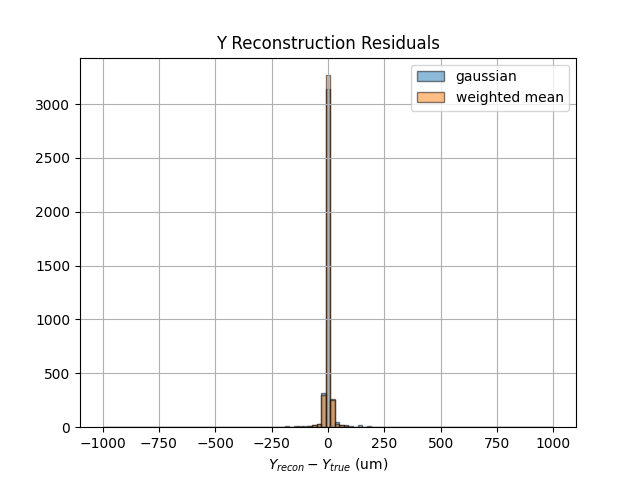

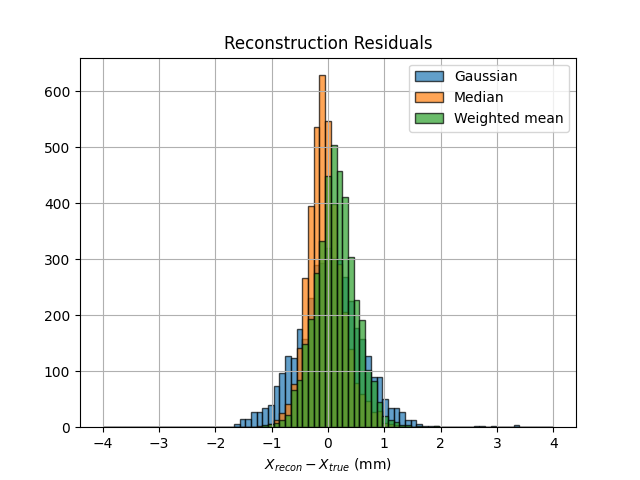

In [40]:

plt.figure()
plt.title('Y Reconstruction Residuals')
plt.grid()
plt.hist(res_y*1000, bins=np.linspace(-1,1,100)*1000, edgecolor='black', alpha=0.5, label='gaussian')
plt.hist(res_y2*1000, bins=np.linspace(-1,1,100)*1000, edgecolor='black', alpha=0.5, label='weighted mean')
plt.xlabel('$Y_{recon} - Y_{true}$ (um)')
plt.legend()

print(np.median(all_x[1]))

plt.figure()
plt.title('Reconstruction Residuals')
plt.hist(res_x, bins=np.linspace(-4,4,80),  edgecolor='black', alpha=0.7, label="Gaussian")
plt.hist(res_x3, bins=np.linspace(-4,4,80),  edgecolor='black', alpha=0.7, label='Median')
plt.hist(res_x2, bins=np.linspace(-4,4,80),  edgecolor='black', alpha=0.7, label='Weighted mean')


plt.xlabel('$X_{recon} - X_{true}$ (mm)')
plt.legend()
plt.grid()

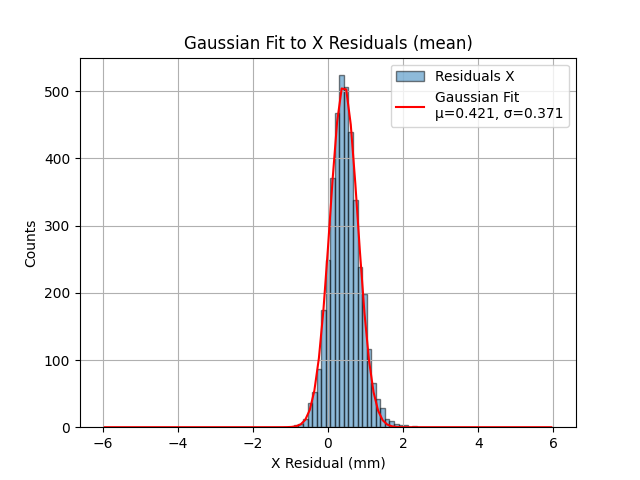

res_x fit: mu = 0.4210, sigma = 0.3706


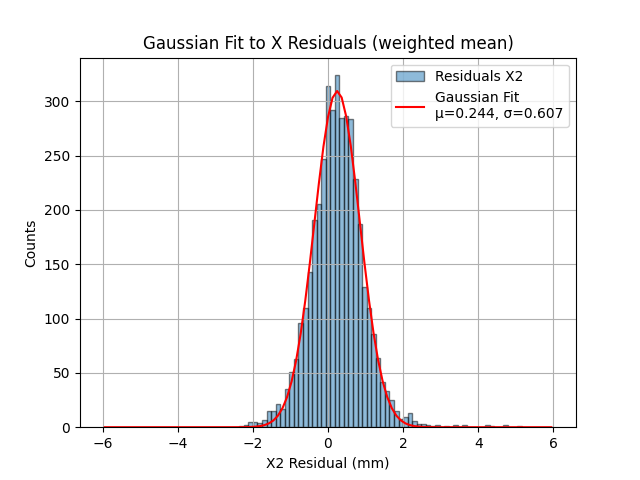

res_x2 fit: mu = 0.2436, sigma = 0.6070


In [60]:
from scipy.optimize import curve_fit

def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

# Fit and plot for res_x
bins_x = np.linspace(-6, 6, 100)
hist_x, edges_x = np.histogram(res_x, bins=bins_x)
centers_x = 0.5 * (edges_x[:-1] + edges_x[1:])
p0_x = [hist_x.max(), np.mean(res_x), np.std(res_x)]
popt_x, _ = curve_fit(gaussian, centers_x, hist_x, p0=p0_x)

plt.figure()
plt.hist(res_x, bins=bins_x, alpha=0.5, edgecolor='black', label='Residuals X')
plt.plot(centers_x, gaussian(centers_x, *popt_x), 'r-', label=f'Gaussian Fit\nμ={popt_x[1]:.3f}, σ={popt_x[2]:.3f}')
plt.xlabel('X Residual (mm)')
plt.ylabel('Counts')
plt.title('Gaussian Fit to X Residuals (mean)')
plt.legend()
plt.grid()
plt.show()

print(f"res_x fit: mu = {popt_x[1]:.4f}, sigma = {popt_x[2]:.4f}")

# Fit and plot for res_x2
bins_x2 = np.linspace(-6, 6, 100)
hist_x2, edges_x2 = np.histogram(res_x2, bins=bins_x2)
centers_x2 = 0.5 * (edges_x2[:-1] + edges_x2[1:])
p0_x2 = [hist_x2.max(), np.mean(res_x2), np.std(res_x2)]
popt_x2, _ = curve_fit(gaussian, centers_x2, hist_x2, p0=p0_x2)

plt.figure()
plt.hist(res_x2, bins=bins_x2, alpha=0.5, edgecolor='black', label='Residuals X2')
plt.plot(centers_x2, gaussian(centers_x2, *popt_x2), 'r-', label=f'Gaussian Fit\nμ={popt_x2[1]:.3f}, σ={popt_x2[2]:.3f}')
plt.xlabel('X2 Residual (mm)')
plt.ylabel('Counts')
plt.title('Gaussian Fit to X Residuals (weighted mean)')
plt.legend()
plt.grid()
plt.show()

print(f"res_x2 fit: mu = {popt_x2[1]:.4f}, sigma = {popt_x2[2]:.4f}")

# Playground with reconstruction

200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200


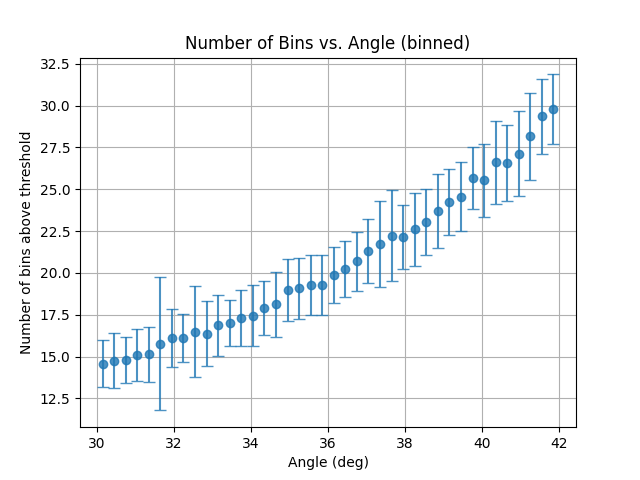

In [61]:
num_bins = []
angles_deg = []

noise_mask = [np.random.normal(0,50, len(histx_ticks[0]))]

x_with_noise = noise_mask+all_x

for xvals, theta in zip(x_with_noise, thetas):
    threshold = 200
    print(threshold)
    above_thresh = xvals > threshold
    if np.any(above_thresh):
        count = np.sum(above_thresh)
        num_bins.append(count)
        angles_deg.append(np.degrees(theta))

num_bins = np.array(num_bins)
angles_deg = np.array(angles_deg)

bin_edges = np.arange(0, 90 + 0.5, 0.5)
bin_centers = 0.3 * (bin_edges[:-1] + bin_edges[1:])
means = []
stds = []
counts = []

for low, high in zip(bin_edges[:-1], bin_edges[1:]):
    mask = (angles_deg >= low) & (angles_deg < high)
    if np.any(mask):
        means.append(np.mean(num_bins[mask]))
        stds.append(np.std(num_bins[mask]))
        counts.append(np.sum(mask))
    else:
        means.append(np.nan)
        stds.append(np.nan)
        counts.append(0)

means = np.array(means)
stds = np.array(stds)
bin_centers = np.array(bin_centers)

plt.figure()
plt.errorbar(bin_centers, means, yerr=stds, fmt='o', capsize=4, alpha=0.8)
plt.xlabel('Angle (deg)')
plt.ylabel('Number of bins above threshold')
plt.title('Number of Bins vs. Angle (binned)')
plt.grid(True)
plt.show()


# Past Playing with the TPC method

NameError: name 'line_func' is not defined

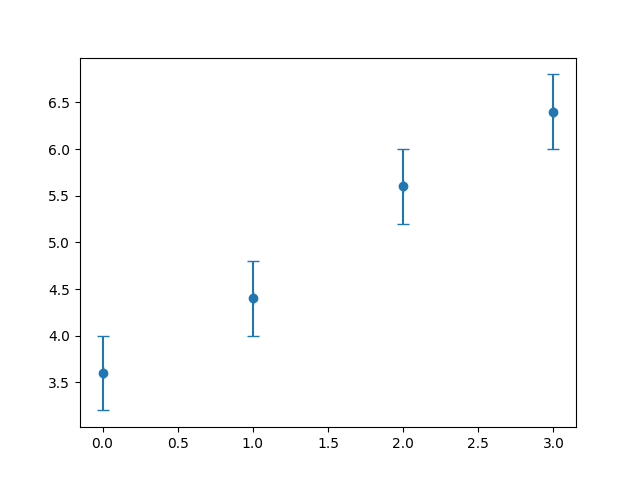

In [52]:
i=9
x_bin_centers = histx_ticks[i]
x_bin_vals = all_x[i]

peaks, _ = find_peaks(x_bin_vals, prominence=100)

plt.figure()
plt.errorbar(
    np.arange(len(peaks)),
    x_bin_centers[peaks],
    xerr=0,
    yerr=bin_width,
    fmt='o',
    label='Peak Positions',
    capsize=4
)

# Linear fit, ignore the first index
if len(peaks) > 1:
    # fit_indices = np.arange(len(peaks))+1  # skip the first index (starts from 2)
    # fit_x = fit_indices
    # fit_y = x_bin_centers[peaks]
    # coeffs, cov = np.polyfit(fit_x, fit_y, 1, cov=True)
    # fit_line = np.polyval(coeffs, fit_x)
    # perr = np.sqrt(np.diag(cov))
    # label = f'Linear Fit (ignore 1st): y={coeffs[0]:.2f}±{perr[0]:.2f}x+{coeffs[1]:.2f}±{perr[1]:.2f}'
    fit_indices = np.arange(len(peaks)) 
    fit_x = fit_indices
    fit_y = x_bin_centers[peaks]
    coeffs, _ = curve_fit(line_func, fit_x, fit_y, p0=[np.radians(30), 0], bounds=([0, -np.inf], [np.radians(60), np.inf]))
    x = line_func(fit_x, *coeffs)
    
    plt.plot(fit_x, x, 'r--')

plt.xlabel('Peak Index')
plt.ylabel('X Bin Center (mm)')
plt.title('Peak Positions vs. Peak Index')
plt.legend()
plt.grid(True)
plt.show()

print(np.degrees(thetas[i]), np.degrees(coeffs[0]))

In [238]:
peak_distances = []

for i, (xvals, theta) in enumerate(zip(all_x, thetas)):
    peaks, _ = find_peaks(xvals, threshold=100)
    if len(peaks) > 1:
        distances = np.diff(peaks) / np.sin(theta)
        avg_distance = np.mean(distances)
        peak_distances.append(avg_distance)

peak_distances = np.array(peak_distances)

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_87137/2879361555.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


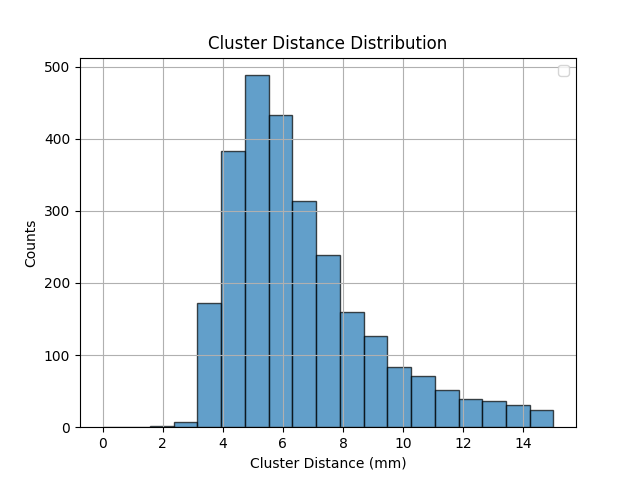

In [304]:
from scipy.optimize import curve_fit

plt.figure()
plt.hist(peak_distances, bins=np.linspace(0, 15, 20), edgecolor='black', alpha=0.7)
plt.grid()
def exp_dist(x, a, lamb):
    return a* lamb * np.exp(-lamb * x)

hist_vals, bin_edges = np.histogram(peak_distances, bins=np.linspace(0, 15, 20))
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

# Only fit where hist_vals > 0 to avoid log(0) issues
mask = hist_vals > 0
popt, pcov = curve_fit(exp_dist, bin_centers[mask], hist_vals[mask], p0=[max(hist_vals/2),0.2])

# plt.plot(bin_centers, exp_dist(bin_centers, *popt), 'r--', label=f'Fit: λ={popt[1]:.3f}')
plt.xlabel('Cluster Distance (mm)')
plt.ylabel('Counts')
plt.title('Cluster Distance Distribution')
plt.legend()

In [305]:
def linfit_reconstruction(bin_tick, bin_count):
    peaks, _ = find_peaks(bin_count, threshold=100)
    # Linear fit, ignore the first index

    if len(peaks) > 1:
        fit_indices = np.arange(len(peaks)) 
        # fit_indices[0] -0.8
        fit_x = fit_indices
        fit_y = x_bin_centers[peaks]
        coeffs = np.polyfit(fit_x, fit_y, 1)
        x = np.polyval(coeffs, 0)
        # perr = np.sqrt(np.diag(cov))
        return x
    else:
        return gaussian_reconstruction(bin_tick, bin_count)[1]

In [327]:
def line_func(x, t, b, k=2):
    return np.sin(t)* k *  x + b

In [402]:
def angle_reconstruction(bin_tick, bin_count):
    peaks, _ = find_peaks(bin_count, threshold=500)
    if len(peaks) >3:
        fit_indices = np.arange(len(peaks)) 
        # fit_indices[0] -0.8
        fit_x = fit_indices
        fit_y = x_bin_centers[peaks]
        coeffs, _ = curve_fit(line_func, fit_x, fit_y, p0=[np.radians(30), 0], bounds=([0, -np.inf], [np.pi/3, np.inf]))
        # perr = np.sqrt(np.diag(cov))
        return coeffs[0]
    else:
        return np.nan

In [403]:
test_recon_t0 = np.zeros(len(all_x))
test_res_t0 = np.zeros(len(all_x))

for i, x in enumerate(all_x):
    print(i)
    test_recon_t0[i] = angle_reconstruction(histx_ticks[0], x)

test_res_t0 = test_recon_t0 - thetas

test_res_t0 = test_res_t0[np.argwhere(thetas > np.radians(50))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

/var/folders/p4/z5pfwnjs7x7d9zcwks7kn0j80000gn/T/ipykernel_87137/1917954777.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


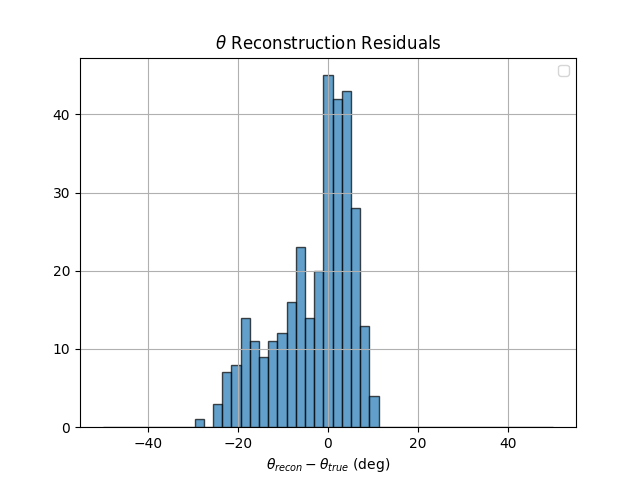

In [404]:
plt.figure()
plt.title('$\\theta$ Reconstruction Residuals')
plt.hist(np.degrees(test_res_t0), bins=np.linspace(-50,50,50),  edgecolor='black', alpha=0.7,)
# plt.hist(res_x2, bins=np.linspace(-10,10,100),  edgecolor='black', alpha=0.7, label='cutoff')
plt.xlabel('$\\theta_{recon} - \\theta_{true}$ (deg)')
plt.legend()
plt.grid()

In [301]:
cands = []

for i, x in enumerate(all_x):
    if len(find_peaks(x, threshold=100)[0]) > 3: 
        cands.append(i)

print(cands)
print(len(cands))

[9, 13, 15, 16, 22, 26, 28, 29, 33, 38, 39, 43, 49, 52, 53, 55, 61, 62, 70, 72, 73, 79, 87, 92, 93, 99, 105, 109, 120, 123, 138, 140, 144, 151, 160, 163, 174, 177, 181, 185, 187, 188, 198, 199, 202, 203, 211, 217, 218, 219, 223, 226, 227, 229, 239, 241, 247, 260, 263, 274, 278, 280, 283, 285, 286, 287, 292, 295, 301, 309, 313, 317, 319, 320, 322, 326, 329, 337, 339, 342, 343, 347, 357, 361, 366, 370, 377, 385, 389, 393, 395, 400, 404, 412, 416, 417, 420, 422, 428, 430, 435, 436, 438, 444, 457, 460, 466, 473, 478, 484, 485, 490, 493, 496, 497, 499, 508, 518, 521, 534, 544, 546, 550, 553, 554, 558, 561, 567, 568, 571, 572, 573, 574, 575, 579, 582, 584, 591, 600, 607, 608, 612, 616, 617, 620, 625, 627, 631, 636, 639, 642, 653, 662, 668, 669, 671, 673, 679, 681, 682, 685, 687, 689, 702, 706, 707, 711, 712, 714, 717, 721, 729, 738, 739, 750, 755, 758, 759, 763, 765, 767, 775, 786, 791, 792, 794, 802, 803, 804, 807, 809, 812, 817, 822, 823, 835, 837, 840, 851, 862, 863, 867, 869, 872, 873, 8

In [747]:
find_peaks(all_x[9])[0]

array([59, 61, 64, 66, 70])

[2.81746545e+04 9.06429121e-01 2.07374055e-01]


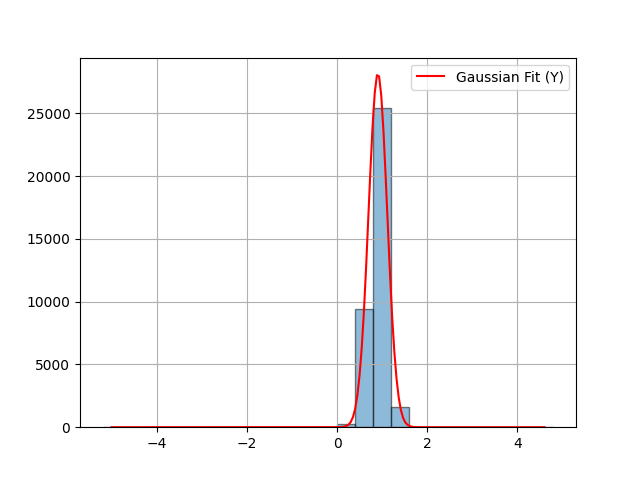

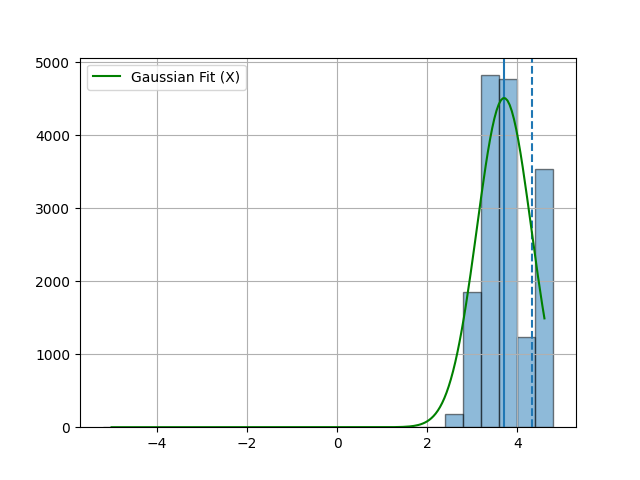

In [575]:
i = 0
plt.figure()
plt.grid(True)
plt.bar(histy_ticks[i], all_y[i],width=bin_width, align='center', edgecolor='black', alpha=0.5)

# Fit a Gaussian to the y histogram data
try:
    popt_y = gaussian_reconstruction(histy_ticks[i], all_y[i])
    y_fit = np.linspace(histy_ticks[i].min(), histy_ticks[i].max(), 200)
    plt.plot(y_fit, gaussian(y_fit, *popt_y), 'r-', label='Gaussian Fit (Y)')
    plt.legend()
    print(popt_y)
    # print('residual of ',popt_y[1] - yts[i])
except Exception as e:
    print("Gaussian fit (Y) failed:", e)

plt.figure()
plt.grid(True)
plt.bar(histx_ticks[i], all_x[i], width=bin_width, align='center', edgecolor='black', alpha=0.5)

popt_x = gaussian_reconstruction(histx_ticks[i], all_x[i])

# plt.axvline()
plt.axvline(popt_x[1])
plt.axvline(xts[i], linestyle='--')

# Fit a Gaussian to the x histogram data
try:
    # popt_x, _ = curve_fit(gaussian, histx_ticks[i],all_x[i], p0=[max(histx_ticks[i]), 0, 1])
    x_fit = np.linspace(histx_ticks[i].min(), histx_ticks[i].max(), 200)
    plt.plot(x_fit, gaussian(x_fit, *popt_x), 'g-', label='Gaussian Fit (X)')
    plt.legend()
    # print(*popt_x)
except Exception as e:
    print("Gaussian fit (X) failed:", e)


In [546]:
res_x[0]

np.float64(-4.316640927748229)

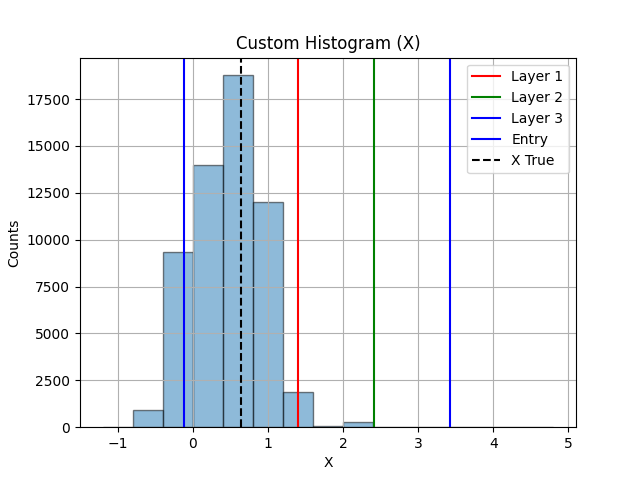

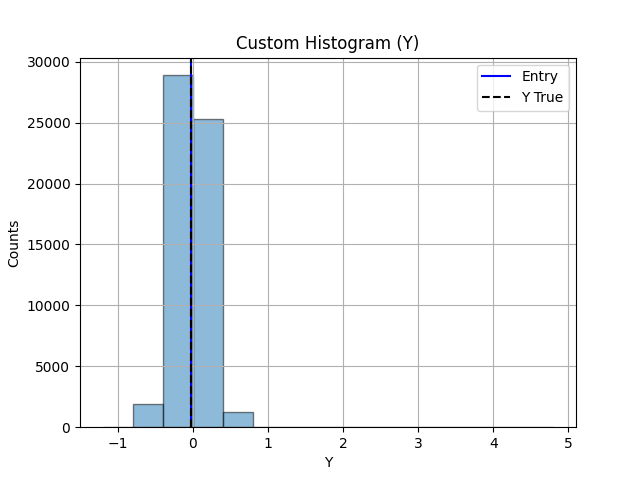

In [307]:
plt.figure()
plt.grid(True)
plt.bar(x_bin_centers, x_bin_vals, width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.axvline(layer_1xs[i], color='r', label='Layer 1')
plt.axvline(layer_2xs[i], color='g', label='Layer 2')
plt.axvline(layer_3xs[i], color='b', label='Layer 3')
plt.axvline(x0s[i], color='b', label='Entry')
plt.axvline(xts[i], color='0', label='X True', linestyle='--')
plt.xlabel('X')
plt.ylabel('Counts')
plt.title('Custom Histogram (X)')
plt.legend()
plt.show()

plt.figure()
plt.grid(True)
plt.bar(y_bin_centers, y_bin_vals, width=bin_width, align='center', edgecolor='black', alpha=0.5)
plt.axvline(y0s[i], color='b', label='Entry')
plt.axvline(yts[i], color='0', label='Y True', linestyle='--')
plt.xlabel('Y')
plt.ylabel('Counts')
plt.title('Custom Histogram (Y)')
plt.legend()
plt.show()

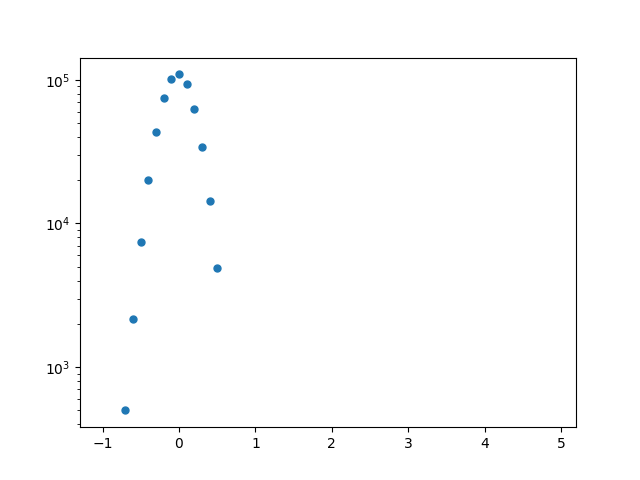

In [292]:
plt.figure()
plt.plot(y_bin_centers, y_bin_vals, 'o', markersize=5)
plt.yscale('log')

In [254]:
means = np.array([np.mean(i) for i in x_arrays]) - 1
means.mean()

np.float64(0.7263031304518934)

In [174]:
for i, (x,j,t) in enumerate(zip(x2_arrays, x0s, thetas)):
    if np.array(x).min() < j and np.degrees(t)>10: print(i)

In [112]:
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

def gaussian_reconstruction(data, bin_width=0.4):
    # Compute histogram
    bins = np.arange(min(data), max(data) + bin_width, bin_width)
    counts, bin_edges = np.histogram(data, bins=bins)
    bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

    # Initial guess: amplitude, mean, std dev
    p0 = [max(counts), np.mean(data), np.std(data)]

    # Fit Gaussian
    try:
        popt, _ = curve_fit(gaussian, bin_centers, counts, p0=p0)
        return popt[1]  # Return the mean (mu)
    except RuntimeError:
        print("Fit failed.")
        return None

In [113]:
recon_x = []
recon_y = []

for x, y in zip(x_arrays, y_arrays):
    recon_x.append(gaussian_reconstruction(x))
    recon_y.append(gaussian_reconstruction(y))

recon_x = np.array(recon_x)
recon_y = np.array(recon_y)

res_x = recon_x - xts
res_y = recon_y - yts

(array([2., 0., 1., 0., 1., 1., 2., 0., 2., 2., 1., 4., 0., 4., 2., 5., 4.,
        2., 5., 2., 5., 4., 2., 2., 5., 4., 2., 1., 3., 2., 1., 1., 3., 0.,
        2., 4., 0., 5., 1., 2., 1., 1., 0., 1., 1., 3., 1., 0., 1., 2.]),
 array([-8.62087906, -8.27061892, -7.92035877, -7.57009862, -7.21983848,
        -6.86957833, -6.51931818, -6.16905804, -5.81879789, -5.46853774,
        -5.1182776 , -4.76801745, -4.4177573 , -4.06749716, -3.71723701,
        -3.36697686, -3.01671672, -2.66645657, -2.31619642, -1.96593628,
        -1.61567613, -1.26541599, -0.91515584, -0.56489569, -0.21463555,
         0.1356246 ,  0.48588475,  0.83614489,  1.18640504,  1.53666519,
         1.88692533,  2.23718548,  2.58744563,  2.93770577,  3.28796592,
         3.63822607,  3.98848621,  4.33874636,  4.68900651,  5.03926665,
         5.3895268 ,  5.73978695,  6.09004709,  6.44030724,  6.79056739,
         7.14082753,  7.49108768,  7.84134782,  8.19160797,  8.54186812,
         8.89212826]),
 <BarContainer object

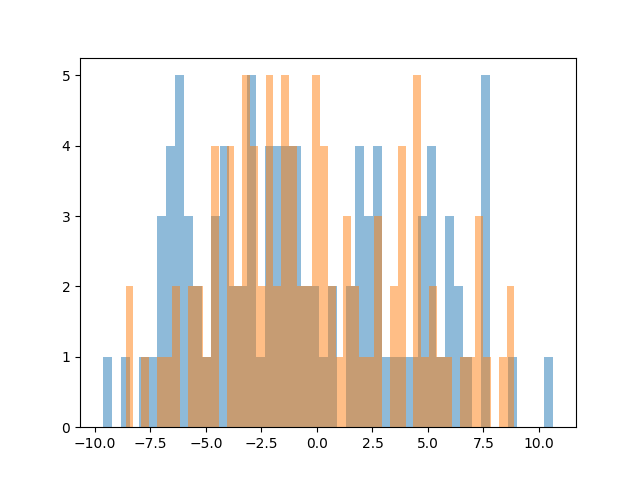

In [114]:
plt.figure()
plt.hist(res_x, bins=50, alpha=0.5)
plt.hist(res_y, bins=50, alpha=0.5)

In [165]:
print("Layer 1 x:", layer_1xs[i])
print("Layer 2 x:", layer_2xs[i])
print("Layer 3 x:", layer_3xs[i])
print(x0s[i])
print(y0s[i])
print(xts[i])

Layer 1 x: 4.739958152238282
Layer 2 x: 6.340500411372637
Layer 3 x: 7.941042670506991
2.3391447635367513
1.0191550059244037
3.5395514578875167


In [190]:
df.AsNumpy

<bound method RDataFrameAsNumpy of <cppyy.gbl.ROOT.RDataFrame object at 0x14278f950>>

In [ ]:
# Define Gaussian function
def gaussian(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x - mu) / sigma) ** 2)

xmin = min(0, min(x_arrays[i]))
xmax = max(x_arrays[i])
bins = np.arange(xmin, xmax + bin_width, bin_width)

bin_counts, bin_edges = np.histogram(x_arrays[i], bins=bins)
bin_centers = 0.5 * (bin_edges[1:] + bin_edges[:-1])

# Initial guess: amplitude, mean, std dev
p0 = [max(bin_counts), np.mean(x_arrays[i]), 1]
popt, pcov = curve_fit(gaussian, bin_centers, bin_counts, p0=p0)

plt.figure()
plt.hist(x_arrays[i], bins=bins, alpha=0.6, label='Data', edgecolor='black')
x_fit = np.linspace(min(x_arrays[i]), max(x_arrays[i]), 1000)
plt.plot(x_fit, gaussian(x_fit, *popt), 'r-', label='Gaussian Fit')

plt.xlabel('Value')
plt.ylabel('Counts')
plt.title('Histogram with Gaussian Fit')
plt.axvline(layer_1xs[i], color='b', linestyle='--', label='Layer 1')
plt.axvline(layer_2xs[i], color='b', linestyle='--', label='Layer 2')
plt.axvline(layer_3xs[i], color='b', linestyle='--', label='Layer 3')
plt.axvline(x0s[i], color='b', linestyle='--', label='Entry')
# plt.legend()
plt.grid()
plt.show()


ValueError: min() iterable argument is empty

# Sanity Check with COOKER stuff

In [ ]:
file = ROOT.TFile.Open("./g4DL_output.root")
if not file or file.IsZombie():
    print("Error opening file.")


# Get the TTree
tree = file.Get("T")
if not tree:
    print("Tree not found.")

# Set up the branch name you want to extract
X_branch = "GEM0_LocalHitX"
Y_branch = 'GEM0_LocalHitY'
# _branch = 'GEM0_LocalHitY'
# T_branch = 'tf'

# Use RDataFrame for convenience
df = ROOT.RDataFrame(tree)

# Convert the branch to a NumPy array
x_arrays = np.array(df.AsNumpy([X_branch])[X_branch]) 
y_arrays = np.array(df.AsNumpy([Y_branch])[Y_branch]) 
# t_arrays = np.array(df.AsNumpy([T_branch])[T_branch]) 



In [32]:
angles = []

for xs, ys in zip(x_arrays, y_arrays):
    xs = np.array(xs)
    ys = np.array(ys)
    if len(xs)==0 or len(ys)==0: 
        angles.append(-1)
        continue
    print(len(xs))
    print(xs)
    dx = xs.max() - xs.min()
    dy = np.max(ys) - np.min(ys)
    angles.append(np.arctan(np.sqrt(dx**2 + dy**2)/3))

angles = 180/3.14159 * np.array(angles)

56
[-107.11226095 -106.98015852 -106.9678011  -106.82613374 -106.79768718
 -106.68755405 -106.6429941  -106.52987034 -106.46350685 -106.38256558
 -106.23912098 -106.14938341 -106.11478717 -106.00014556 -105.97239442
 -105.84970151 -105.80481017 -105.66705705 -105.59239023 -105.54957012
 -105.43887953 -105.33862165 -105.2762493  -105.18784206 -105.06048462
 -105.01024215 -104.93085026 -104.84412111 -104.73264528 -104.6584285
 -104.55670846 -104.54586206 -104.40394905 -104.32585936 -104.28938641
 -104.20690429 -104.05217675 -103.98839848 -103.88163332 -103.82109449
 -103.71268466 -103.63851144 -103.61184152 -103.46689814 -103.37974413
 -103.29332818 -103.20718052 -103.15502722 -103.09472025 -102.99785951
 -102.91379813 -102.86862006 -102.71690199 -102.69402267 -102.53561791
 -102.47344369]
55
[56.15862724 56.27690728 56.36963084 56.42196133 56.48493665 56.55678821
 56.65382954 56.7320505  56.85277656 56.88433883 57.04102444 57.05841294
 57.14736277 57.24535752 57.30360043 57.42943556 57.

In [37]:
np.argwhere((59 < angles) & (angles < 61))

array([[ 18],
       [ 52],
       [ 53],
       [115],
       [139],
       [186],
       [197],
       [220],
       [237],
       [241],
       [269],
       [271],
       [287],
       [322],
       [333],
       [358],
       [360],
       [415],
       [459],
       [464],
       [493],
       [514],
       [566],
       [587],
       [603],
       [619],
       [623],
       [632],
       [660],
       [664]])

In [36]:
angles[12:14]

array([39.94596631, 47.77983487])

In [18]:
xs.max()

np.float64(-102.47344368921426)